<a href="https://colab.research.google.com/github/georgsmeinung/rn4-multilayer-percep/blob/main/RN-Clase04/Pr%C3%A1ctica%204%20-%20Notebooks/04_colores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiperceptrón - Nombres de Colores

---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [1]:
def entorno_de_trabajo():
    if 'google.colab' in str(get_ipython()): return "colab"  # Colab?
    else: return "local"  # Local => Linux, Windows, WSL

if entorno_de_trabajo() == 'colab': # maquina virtual colab
    from google.colab import drive
    drive.mount('/content/drive/')  # monta G-drive en entorno COLAB

    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'  # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else: # entorno local # Rutas relativas al script para entornos locales Windows, WSL y Linux
    FUENTES_DIR = '../../FUENTES/'  # Ajusta según tu estructura
    DATOS_DIR = '../../DATOS/'

import sys
sys.path.append(FUENTES_DIR) # agrega ruta de busqueda donde tenemos archivos .py

Mounted at /content/drive/


### Carga de Datos

In [2]:
import pandas as pd      # para trabajar con archivos de datos csv, excel
import chardet           # para detectar la codificación de texto en archivos
import numpy as np

from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt

from IPython.display import display
import ipywidgets as widgets
import plotly.graph_objects as go
import plotly.express as px


nombre_archivo = DATOS_DIR + 'rgb_colores.csv' # archivo de hojas

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

# recupera el archivo en un objeto dataframe de pandas utilizando la codificación detectada
# %% Carga de dataset con formato R, G, B, Color
df = pd.read_csv(nombre_archivo, encoding=result['encoding'])

display(df)

# Crear el histograma
fig = px.histogram(df, x='Color', title="Distribución de colores")
fig.update_layout(xaxis_title="Color", yaxis_title="Frecuencia")
fig.show()

,R,G,B,Color
0,20,139,240,Azul
1,174,83,72,Marron
2,144,249,131,Verde
3,168,25,156,Rosa
4,30,182,136,Verde
...,...,...,...,...
5047,26,26,26,Negro
5048,27,27,27,Negro
5049,28,28,28,Negro
5050,29,29,29,Negro


### Selección de Atributos Independientes y Target. Gráfico del Espacio

In [3]:
# dibuja puntos en el espacio. utiliza posición RGB para posicionar y pintar
R = np.array(df.iloc[:,0])
G = np.array(df.iloc[:,1])
B = np.array(df.iloc[:,2])
C = np.array(df.iloc[:,0:-1])
Nombre = df.iloc[:,-1]

# %% Preprocesamiento de datos para el entrenamiento
binarizer = preprocessing.LabelBinarizer()
scaler = preprocessing.MinMaxScaler()

Y_bin = binarizer.fit_transform(Nombre)
X_raw = np.array(C)

X = scaler.fit_transform( X_raw )
Y = np.array(Y_bin.tolist())

### Gráfico de Frecuencia de Clases

Text(0.5, 0, 'Azul')

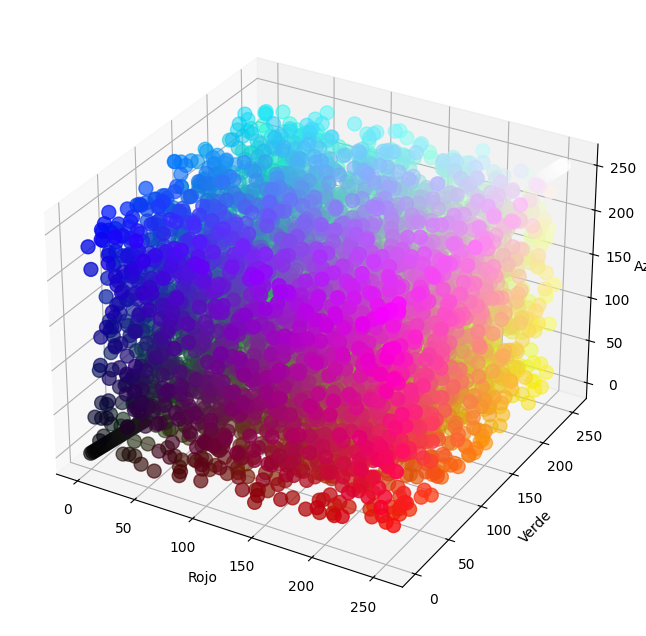

In [4]:
# prepara gráficos de todos los puntos
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')

ax.scatter(R, G, B, c = C/255.0, s=100 )

ax.set_xlabel('Rojo')
ax.set_ylabel('Verde')
ax.set_zlabel('Azul')


### Gráfico con puntos en el Espacio de Color RGB

In [5]:
# Eliminar aleatoriamente elementos del DataFrame para dibujar mas rapido
df_graf = df.sample(frac=0.20, random_state=1)  # Mantener % de las filas

# Agrega la columna 'RGB' al DataFrame df_graf
df_graf['RGB']= df_graf.apply(lambda row: f'#{row["R"]:02x}{row["G"]:02x}{row["B"]:02x}', axis=1)

# Gráfica ejemplos según propiedades en 3D
fig = px.scatter_3d(
    df_graf,
    x='R',
    y='G',
    z='B',
    color='RGB', # atributo del dataframe para el color
    title='Colores en 3D',
    color_discrete_map={color: color for color in df_graf['RGB']},
    hover_data=['Color']  # Añadir 'nombre' al hover
)


fig.update_layout(showlegend=False) # Sin leyendas

fig.show()

df_graf

,R,G,B,Color,RGB
3472,188,210,145,Amarillo,#bcd291
2860,66,184,240,Azul,#42b8f0
1796,198,137,245,Violeta,#c689f5
4021,157,224,184,Verde,#9de0b8
1675,252,11,175,Rosa,#fc0baf
...,...,...,...,...,...
4388,244,154,178,Rosa,#f49ab2
2878,73,60,56,Marron,#493c38
2727,4,161,179,Azul,#04a1b3
107,207,221,69,Amarillo,#cfdd45


### Generación y Evaluación del Modelo

In [6]:
ENTRADAS = X.shape[1]
SALIDAS  = Y.shape[1]
ACTIVACION = 'tanh'   # TF vs SkLearn linear => identity, sigmoid => logistic, tanh => tanh, relu => relu
EPOCAS = 250
TAM_LOTE = 64
ALFA = 0.008

print(X.shape)

modelo = Sequential()
modelo.add(Input(shape=(ENTRADAS,)))
modelo.add(Dense(16, activation=ACTIVACION))
modelo.add(Dense(16, activation=ACTIVACION))
modelo.add(Dense(SALIDAS, activation='softmax'))

modelo.summary()

optimizador = optimizers.Adam(learning_rate=ALFA)
# obtiene la arquitectura para el modelo y lo compila
modelo.compile(optimizer='SGD', loss='categorical_crossentropy', metrics = ['accuracy'])

# Entrena el modelo y guarda la historia del progreso
history = modelo.fit(x=X, y=Y, batch_size=TAM_LOTE, validation_split=0.30, epochs=EPOCAS)


Y_pred = modelo.predict(X)
#score = modelo.score(X, Y)

# "invierte" la transformacion binaria para obtener los nombres de las clases
Y_it = binarizer.inverse_transform(Y)
Y_pred_it = binarizer.inverse_transform(Y_pred)

#print(Y,'\n')
#print(Y_it)


(5052, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │           187 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523 (2.04 KB)

 Trainable params: 523 (2.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0855 - loss: 2.3739 - val_accuracy: 0.2513 - val_loss: 2.2063
Epoch 2/250
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3389 - loss: 2.1282 - val_accuracy: 0.3582 - val_loss: 2.0828
Epoch 3/250
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4303 - loss: 1.9988 - val_accuracy: 0.4294 - val_loss: 2.0027
Epoch 4/250
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5101 - loss: 1.8948 - val_accuracy: 0.4446 - val_loss: 1.9411
Epoch 5/250
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4900 - loss: 1.8414 - val_accuracy: 0.4380 - val_loss: 1.8869
Epoch 6/250
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4843 - loss: 1.7695 - val_accuracy: 0.4387 - val_loss: 1.8346
Epoch 7/250
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4763 - loss: 1.7105 - val_accuracy: 0.4466 - val_loss: 1.7829
Epoch 8/250
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5002 - loss: 1.6590 - val_accuracy: 0.4683 - v

Efectividad:  85.31%


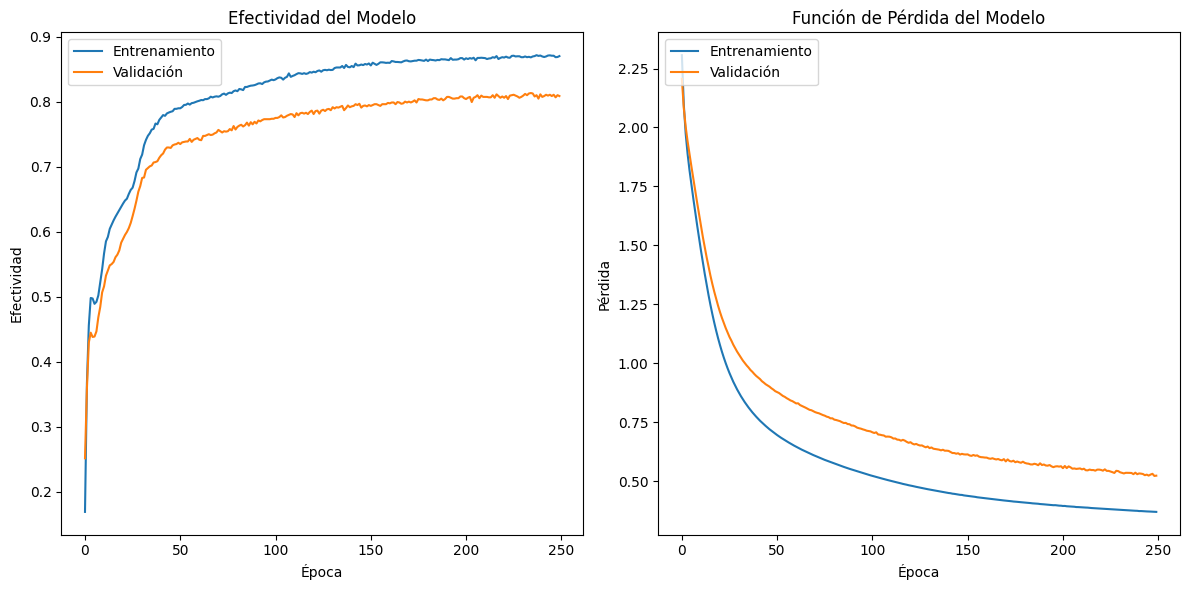

In [7]:
import matplotlib.pyplot as plt

# Calcular la efectividad
efectividad = (Y_pred_it == Y_it).sum() / len(Y_it)
print('Efectividad: %6.2f%%' % (100 * efectividad))

plt.figure(figsize=(12, 6))

# Gráfico de la efectividad
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Efectividad del Modelo')
plt.ylabel('Efectividad')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Gráfico de la función de pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Función de Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.tight_layout()
plt.show()

El color con componentes RGB = (240,  0,200) es Rosa
El color con componentes RGB = (100,100,200) es Azul
El color con componentes RGB = (181,140,110) es Marron
El color con componentes RGB = ( 10,200, 50) es Verde


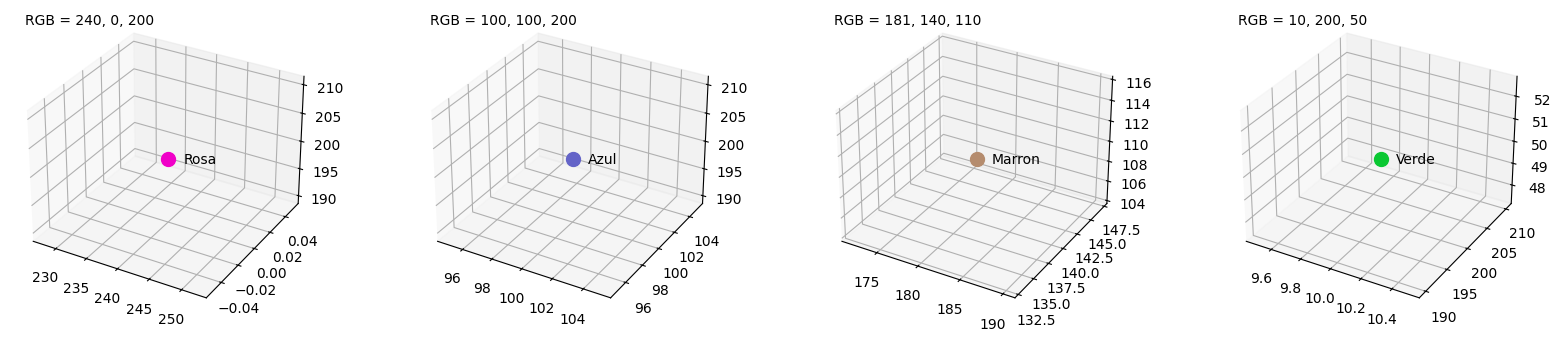

In [8]:
# Ejemplo de función proporcionada para obtener el nombre del color
def nombre_color(R, G, B):
    x_clr = np.array([[R, G, B]])
    x_clr = scaler.transform(x_clr)  # Escalar los valores RGB
    y_clr = modelo.predict(x_clr, verbose=0)  # Clasificar para obtener el nombre del color
    return binarizer.inverse_transform(y_clr)[0]  # Devolver el nombre del color


# %% prueba de un punto individual
def probar_color(color, fig, pos, maxpos=4):
    R, G, B = color[0], color[1], color[2]  # selecciona color

    y_clr_name= nombre_color(R, G, B) # clasifica el color para obtener el nombre

    print('El color con componentes RGB = (%3d,%3d,%3d) es %s' % (R,G,B, y_clr_name))

    # visualizacion del color en el espacio 3D
    ax = fig.add_subplot(1, maxpos, pos, projection='3d')

    ax.scatter(np.array([[R]]), np.array([[G]]), np.array([[B]]), c = np.array([[R,G,B]])/255.0, s=100 )

    ax.text(R*1.01, G, B, y_clr_name)
    ax.text2D(0.05, 0.95, f'RGB = {R}, {G}, {B}', transform=ax.transAxes)


fig = plt.figure(figsize=(20,4))
probar_color((240,   0, 200), fig, 1)
probar_color((100, 100, 200), fig, 2)
probar_color((181, 140, 110), fig, 3)
probar_color(( 10, 200,  50), fig, 4)
plt.show()

In [9]:
# Crear sliders RGB
r_input = widgets.IntSlider(description='Rojo:', min=0, max=255, value=20, continuous_update=True)
g_input = widgets.IntSlider(description='Verde:', min=0, max=255, value=200, continuous_update=True)
b_input = widgets.IntSlider(description='Azul:', min=0, max=255, value=50, continuous_update=True)

# Cuadro de color que mostrará el color actual
color_box = widgets.HTML(
    value=f"<div style='width:100px; height:100px; background-color:rgb(0,0,0);'></div>"
)

# Etiqueta para mostrar el nombre del color
color_name_label = widgets.Label(value="Color: ---")

# Función para actualizar el cuadro de color y el nombre del color
def actualizar_color(change):
    r = r_input.value
    g = g_input.value
    b = b_input.value
    # Actualizar el cuadro de color
    color_box.value = f"<div style='width:100px; height:100px; background-color:rgb({r},{g},{b});'></div>"
    # Actualizar el nombre del color usando la función `nombre_color`
    color_name_label.value = f"Color: {nombre_color(r, g, b)}"

# Vincular la función a los cambios en los sliders
r_input.observe(actualizar_color, 'value')
g_input.observe(actualizar_color, 'value')
b_input.observe(actualizar_color, 'value')

# Mostrar los widgets
#display(widgets.VBox([r_input, g_input, b_input, color_box, color_name_label]))
# Organizar los widgets y la gráfica
inputs = widgets.VBox([r_input, g_input, b_input])
outputs= widgets.VBox([color_box, color_name_label])
layout = widgets.HBox([inputs, outputs])

display(layout)

actualizar_color(None)